### TensorFlow 2.0 선택
[런타임] -> [런타임 유형변경]에서 하드웨어 가속기를 꼭 GPU로 설정!

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
## Importing Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.1.0-rc1
2.2.4-tf


# Inference Only by Pretrained MobileNet

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [0]:
img_size = 224

In [0]:
## Pretrained MobileNet 가져오기
conv_base = MobileNet(weights='imagenet', include_top=True, input_shape=(img_size, img_size, 3))

17227776/17225924 [==============================] - 0s 0us/step


In [0]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [0]:
## Google Drive로 이동
cd '/content/drive/My Drive/mobis_dl_practice'

/content/drive/My Drive/mobis_dl_practice


In [0]:
## Test image 열기
from PIL import Image
test_img = Image.open('data/guitar.jpg')
test_img = test_img.resize((img_size, img_size))
test_img = np.asarray(test_img)
test_img = np.reshape(test_img, (-1, img_size, img_size, 3))
test_img.shape

(1, 224, 224, 3)

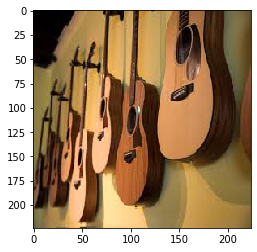

In [0]:
plt.imshow(test_img[0])
plt.show()

In [0]:
## MobileNet으로 inference하기
prediction = conv_base.predict(preprocess_input(test_img))
print(test_img.shape)
print(preprocess_input(test_img).shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


In [0]:
## 예측결과확인
np.argmax(prediction)

402

In [0]:
decode_predictions(prediction, top=5)

40960/35363 [==================================] - 0s 0us/step


[[('n02676566', 'acoustic_guitar', 0.5215823),
  ('n02992211', 'cello', 0.27240372),
  ('n03272010', 'electric_guitar', 0.10318701),
  ('n04208210', 'shovel', 0.046063133),
  ('n04536866', 'violin', 0.017287519)]]

# Fine-tuning Pretrained MobileNet

In [0]:
from tensorflow.keras.layers import ReLU,Dense, BatchNormalization, Softmax, GlobalAveragePooling2D

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [0]:
## HyperParameters
learning_rate = 0.0001
training_epochs = 10
batch_size = 100
img_size = 224
n_class = 10

In [0]:
## Data 준비

## MNIST Dataset #########################################################
#mnist = keras.datasets.mnist
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Cifar10 Dataset #########################################################
cifar = keras.datasets.cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
############################################################################

In [0]:
## data preprocessing - resize image
def img_resize(images, labels):
  return tf.image.resize(images, (img_size, img_size)), labels

In [0]:
## Dataset 만들기
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()    
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
#train_images = np.expand_dims(train_images, axis=-1)
#test_images = np.expand_dims(test_images, axis=-1)
print(train_images.shape)
print(test_images.shape)
n_train = train_images.shape[0]
n_test = test_images.shape[0]
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10) 

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=50000).batch(batch_size).map(img_resize).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(
                batch_size).map(img_resize)

In [0]:
## Load Pretrained Model
conv_base = MobileNet(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))
conv_base.summary()
#conv_base.trainable = False
#conv_base.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [0]:
## Model 만들기
def create_model():
    model = keras.Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Softmax())
    return model

In [0]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                4

In [0]:
## Model Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
steps_per_epoch = n_train/batch_size
validation_steps = n_test/batch_size

model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 14s 139ms/step - loss: 3.2566 - accuracy: 0.0964


[3.2565650367736816, 0.0964]

In [0]:
## Training
history = model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 500.0 steps, validate for 100.0 steps
Epoch 1/10
500/500 [==============================] - 218s 435ms/step - loss: 0.7938 - accuracy: 0.8292 - val_loss: 0.5440 - val_accuracy: 0.9061
Epoch 2/10
500/500 [==============================] - 213s 426ms/step - loss: 0.4794 - accuracy: 0.9387 - val_loss: 0.4501 - val_accuracy: 0.9294
Epoch 3/10
500/500 [==============================] - 213s 427ms/step - loss: 0.3645 - accuracy: 0.9738 - val_loss: 0.4443 - val_accuracy: 0.9364
Epoch 4/10
500/500 [==============================] - 214s 428ms/step - loss: 0.2928 - accuracy: 0.9896 - val_loss: 0.3973 - val_accuracy: 0.9409
Epoch 5/10
500/500 [==============================] - 213s 426ms/step - loss: 0.2401 - accuracy: 0.9968 - val_loss: 0.3744 - val_accuracy: 0.9417
Epoch 6/10
500/500 [==============================] - 214s 428ms/step - loss: 0.2039 - accuracy: 0.9990 - val_loss: 0.3323 - val_accuracy: 0.9460
Epoch 7/10
500/500 [==============================] - 214s 428ms/step - loss

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

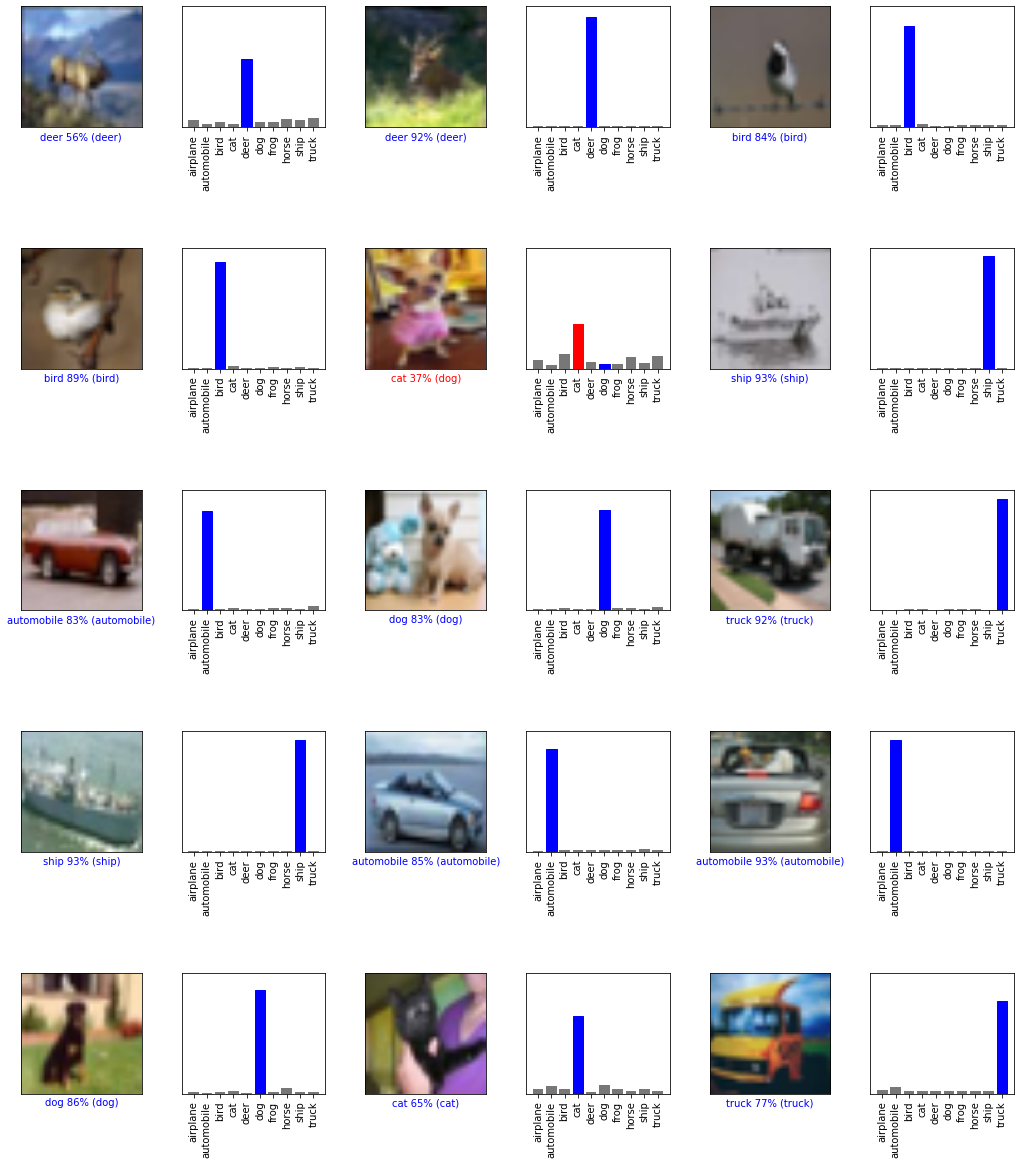

In [0]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break